# RRSG 2019 Challenge 

<div class="alert alert-info">
  <strong><span class="badge">BLUE BOX</span></strong> <b> Steps involving RRSG 2019 challenge tasks</b> 
</div>

<div class="alert alert-warning">
  <strong><span class="badge">YELLOW BOX</span></strong> <b> Additional steps for demonstration </b> 
</div>

<div class="alert alert-danger">
  <strong><span class="badge">RED BOX</span></strong> <b> Warnings to the user</b> 
</div>


In [52]:
% Load octave packages 
pkg load image 
pkg load optim

## 1. Load ISMRM RRSG 2019 challenge data.

<div class="alert alert-info">
  <strong><span class="badge">1.1</span></strong> <b>Please see this <a href="https://osf.io/xne9w/">OSF page</a> for details.</b> 
</div>


In [1]:
load('/tmp/rrsg_challenge/brain_radial_96proj_12ch.mat');
whos % Show variables in the current scope 

Variables in the current scope:

   Attr Name            Size                     Bytes  Class
   ==== ====            ====                     =====  ===== 
        ans             1x5                          5  char
   c    rawdata        12x96x512               4718592  single
        trajectory     96x512x3                 589824  single

Total is 737285 elements using 5308421 bytes



<div class="alert alert-info">
  <strong><span class="badge">1.2</span></strong> <b>Change data order to follow BART's dimension convention</b> 
</div>

<div class="alert alert-danger">
  <strong><span class="badge">Warning</span></strong> <b>Do not run the following cell more than once after loading data (previous cell).</b><br> Otherwise, data will be permutted once again and won't be following BART's convention anymore.

</div>


In [2]:
rawdata = permute(rawdata,[4,3,2,1]); 
trajectory = permute(trajectory,[3,2,1]);
[~,nFE,nSpokes,nCh] = size(rawdata);
whos

Variables in the current scope:

   Attr Name            Size                     Bytes  Class
   ==== ====            ====                     =====  ===== 
        ans             1x5                          5  char
        nCh             1x1                          8  double
        nFE             1x1                          8  double
        nSpokes         1x1                          8  double
   c    rawdata         1x512x96x12            4718592  single
        trajectory      3x512x96                589824  single

Total is 737288 elements using 5308445 bytes



<div class="alert alert-warning">
  <strong><span class="badge">1.3</span></strong> <b>Display raw data from each channel.</b> 
</div>

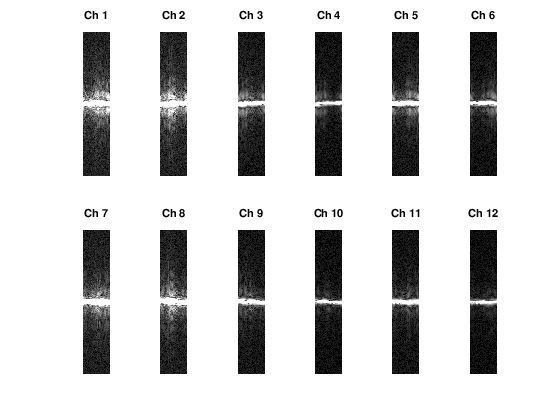

In [3]:
for ii=1:12
cc = squeeze((rawdata(1,:,:,ii)));
% Brighten convention is not 1/1 with matlab.  
subplot(2,6,ii);
imshow(log(1+abs(cc)),[-0 0.0001]); brighten(0.4); title(['Ch ' num2str(ii)]);
end

<div class="alert alert-warning">
  <strong><span class="badge">1.4</span></strong> <b>Display k-space data on trajectories</b> 
</div>

In [4]:
ksp_rss = bart('rss 8', rawdata);
%figure();
lg_ksprss = log(ksp_rss);
lg_ksprss = abs(squeeze(lg_ksprss)); 
dsp = reshape(lg_ksprss,[1 nFE*nSpokes]);


In [ ]:
% This may take some time in Octave... 
%scatter3(trajectory(1, :), trajectory(2,:),trajectory(3,:)[],dsp); colormap('hot');

% Even this one takes a long time 
scatter(trajectory(1, :), trajectory(2,:),[],dsp); colormap('hot');

## 2. Estimate coil sensitivities using BART
***

<div class="alert alert-info">
  <strong><span class="badge">2.1</span></strong> <b>Use BART to estimate coil sensitivities</b> 
</div>

In [76]:
% Adjoint NUFFT to interpolate data onto cartesian grid. 
% -d denotes dimension (x:y:z, which is 300X300X1)
% -a denotes adjoint transform
% -i denotes inverse transform

adj = bart('nufft -d300:300:1 -i',trajectory,rawdata);

% Transform regridded image back to k-space 
% 7 is for bitmasking 

adjk = bart('fft -u 7', adj);

% Estimate coil sensitivities using the k-space center (radius of 20). 

calib = bart('caldir 20',adjk);

Done.
Calibration region 20x20x1
Done.


<div class="alert alert-warning">
  <strong><span class="badge">2.2</span></strong> <b>Display sensitivity profiles</b>
</div>


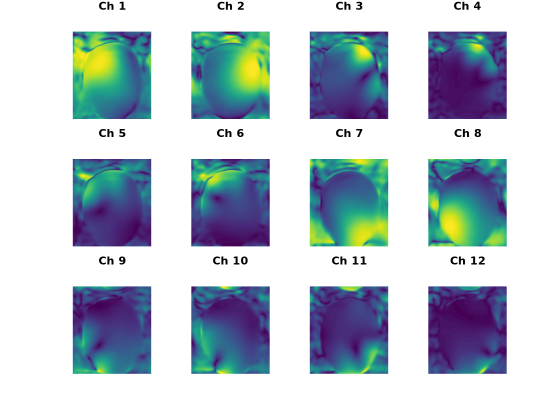

In [98]:
figure();
for ii=1:12
subplot(3,4,ii);
imagesc(log(1+abs(calib(:,:,1,ii)))); axis off; title(['Ch ' num2str(ii)]);
end

## 3. Reconstruction function 

<div class="alert alert-warning">
  <strong><span class="badge">3.0</span></strong> <b>Use SENSE recon (both cartesian and non-cartesian) provided by BART for demonstration</b> 
</div>

<div class="alert alert-warning">
  <strong><span class="badge">3.0.1</span></strong> <b>Cartesian SENSE (BART) using k-space data obtained by fft of nufft</b> 
</div>

In [115]:
% Use gridded data for SENSE recon --> BART PICS 
bart_SENSE = bart('pics -l2', adjk, calib);
imshow(rot90(abs(bart_SENSE),[]))

Size: 65536 Samples: 65536 Acc: 1.00
l2 regularization: 0.000000
conjugate gradients
Total Time: 1.149170
error: rot90: K must be a single real integer
error: called from
    rot90 at line 68 column 5


<div class="alert alert-warning">
  <strong><span class="badge">3.0.2</span></strong> <b>Non-Cartesian SENSE (BART) using provided data</b> 
</div>

conjugate gradients
Total Time: 2.998426


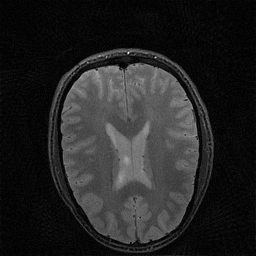

In [79]:
% Use non-cartesian SENSE recon --> BART PICS 
bart_SENSE2 = bart('pics -t',trajectory, rawdata, calib);
imshow(abs(bart_SENSE2),[]);

<div class="alert alert-info">
  <strong><span class="badge">3.1</span></strong> <b>Subsample provided data by factors of 2, 3 and 4.</b>
</div>


In [99]:
% Please see HelperFunctions folder for subSample.m 

[outRD_x2, outTR_x2] = subSample(rawdata,trajectory,2,nSpokes);

[outRD_x3, outTR_x3] = subSample(rawdata,trajectory,3,nSpokes);

[outRD_x4, outTR_x4] = subSample(rawdata,trajectory,4,nSpokes);

<div class="alert alert-warning">
  <strong><span class="badge">3.2</span></strong> <b>Use non-cartesian SENSE recon (BART) to observe the effects of subsampling</b>
</div>


In [100]:
% BART non-cartesian sense outputs 
bart_SENSE2_x2 = bart('pics -t',outTR_x2, outRD_x2, calib);
bart_SENSE2_x3 = bart('pics -t',outTR_x3, outRD_x3, calib);
bart_SENSE2_x4 = bart('pics -t',outTR_x4, outRD_x4, calib);

conjugate gradients
Total Time: 6.339225
conjugate gradients
Total Time: 6.501694
conjugate gradients
Total Time: 6.544617


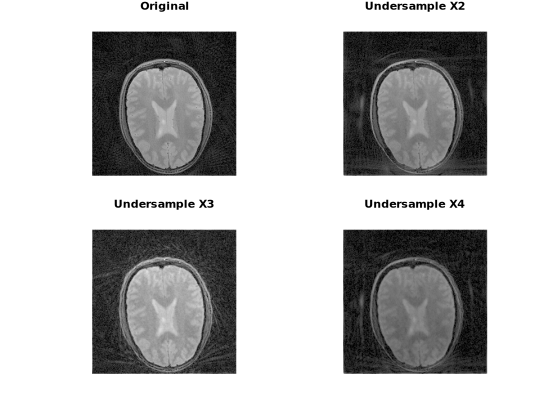

In [101]:
figure();
subplot(2,2,1); imshow(abs(bart_SENSE2),[]); title('Original');
subplot(2,2,2); imshow(abs(bart_SENSE2_x2),[]); brighten(0.5); title('Undersample X2');
subplot(2,2,3); imshow(abs(bart_SENSE2_x3),[]); brighten(0.5); title('Undersample X3');
subplot(2,2,4); imshow(abs(bart_SENSE2_x4),[]); brighten(0.5); title('Undersample X4');


<p style="color:navy;font-size:16px; background-color:powderblue; border-left: 6px solid navy; display: inline-block"> &nbsp; <i class="fa fa-info-circle fa-1x" style="color:darkblue"></i>  <b>Reminder: Figure-1 from the paper&nbsp;</b></p> <br>

<br>

<div class="row">
<div class="col-sm-5" style="padding-right:5px">
<img src="https://wol-prod-cdn.literatumonline.com/cms/attachment/2594c4ea-88e5-4078-b0ea-9893a6554853/mfig001.jpg" style="width:500px;height:400px" align="left">
</div>
<div class="col-sm-7" style="background-color:powderblue">
<p style="font-size:12px; padding-left:15px"> <b>Implementation of iterative image reconstruction.</b><br><br> Conjugate gradient (CG) iteration is controlled by the central CG process. It is initialized by MR data originating from N receiver channels (1,2,3,…N), acquired with an arbitrary k‐space trajectory. <br> Separately for each channel, these data undergo processing similar to conventional gridding reconstruction, i.e., sampling density correction (D), and resampling along a Cartesian grid, followed by FFT (FT1). The resulting images are individually multiplied by complex conjugate coil sensitivity and summed. After subsequent intensity correction (I), the sum image represents the vector a as defined by Eq. [25]. After initialization with a, the CG process iteratively calculates a progression of images, which converges towards exact reconstruction. For each iteration step, a current residuum image vector needs to be multiplied by the matrix IEH DEI. This is performed by the loop which starts from the CG box. After initial intensity correction (I), the processing is continued separately for each receiver coil. First, the intensity corrected residuum image is multiplied by individual coil sensitivity (Si). The results are transformed into k‐space by FFT and resampled along the experimental k‐space trajectory (FT2), resulting in a set of multiple‐coil k‐space data similar to that obtained experimentally. The following steps are equivalent to those carried out with the original data, yielding an intermediate image, which is fed back into the CG process. Here a refined approximate solution is calculated, which serves for further refinement by continued iteration. <br>As soon as the current approximation is sufficiently accurate, it is output and undergoes final intensity correction and k‐space filtering.</p>
</div>
</div>


<p style="color:navy;font-size:16px; background-color:powderblue; border-left: 6px solid navy; display:inline-block"> &nbsp; <i class="fa fa-info-circle fa-1x" style="color:darkblue"></i>  <b> Implementation notes &nbsp; </b></p>

* <p style="border:1px;border-style:solid;display:inline-block"> &nbsp;FT1&nbsp; </p> <b>&</b> <p style="border:1px;border-style:solid;display:inline-block"> &nbsp;D&nbsp; </p> <b>operations are implemented using BART's NUFFT:</b> <br>

```python 
# -d denotes dimensions in x:y:z
# -i denotes inverse transform

transformed = bart('nufft -d x:y:z -i',trajectory,rawdata); 

```

* <p style="border:1px;border-style:solid;display:inline-block"> &nbsp;S<sub>$\gamma$</sub>&nbsp; </p> <b> coil sensitivities are estimated using BART's CALDIR. See section 2.1</b>
    
```python
# 20 denotes calibration region size
# Conjugate transform is simply performed using Octave's conj function

S = bart('caldir 20',kspace); 
```

* <p style="border:1px;border-style:solid;display:inline-block"> &nbsp;FT2&nbsp; </p> <b>is implemented using BART's FFT:</b> <br>

```python
# -u stands for unitary
Output = bart('fft -u bitmask',input); 
```

* <p style="border:1px;border-style:solid;display:inline-block; border-radius:50%"> &nbsp;Sum&nbsp; </p> <b>is implemented using BART's RRS:</b> <br>

```python
Sum = bart('rss bitmask',input); 
```


In [53]:
% Move this to the helper functions 

function [outRD, outTR] = subSample(RD,TR,factor,nSpokes)

    outTR = TR(:,:,1:factor:nSpokes);
    outRD = RD(:,:,1:factor:nSpokes,:);

end

In [190]:
size(calib)
size(trajectory)
size(rawdata)

tt = conj(calib(:,:,1,:));
gg = conj(calib(:,:,1,1));

wt = mri_density_comp(trajectory,'voronoi');

ans =

   256   256     1    12

ans =

     3   512    96

ans =

     1   512    96    12

parse error near line 225 of file /home/agah/mri_density_comp.m

  syntax error

>>> im clf, im pl 2 3
         ^



In [159]:
function a = calc_a(Traj,Raw,S,N)

# Conjugate gradient of coil sensitivities
Sstar = conj(S(:,:,1,:)); % Leaving singleton dimension on purpose 

# Apply NUFFT to interpolate data on cartesian grid --> image domain
tmp = bart('nufft -d300:300:1 -i',Traj,Raw);

# Combine images (multiplied by S*) from each channel
EH = bart('rss 8',Sstar.*tmp)(:);

a = I*EH;

end

In [156]:
function I = calc_I(S,N)

I = eye(N^2); % Initialize N^2 X N^2 identity matrix

# Root sum of square of sensitivities from 12 channels 
tmp = (1./bart('rss 8',S))(:);

# Assign intensity correction matrix (diagonal) entries
for ii=1:length(tmp)
    I(ii,ii) = tmp(ii);
end

end

In [ ]:
function E = calc_E(S,inp)

tmp = S.*inp;
bart('fft -u 7')

end

In [160]:
a = calc_a(trajectory,rawdata,calib,300);

Done.


In [174]:
size(calib)
cc = reshape(a,[300,300]);
size(cc)

dd = calib.*cc;

size(dd)

yy = bart('fft -u 7',dd);



ans =

   256   256     1    12

ans =

   256   256

ans =

   256   256     1    12



In [162]:
function calc_cg(a,I,epsilon)



end

ans =

   65536       1



In [186]:
xxx = bart('nufft -d300:300:1 -a -t',trajectory,rawdata);
size(xxx)
size(rawdata)

Done.
ans =

   300   300     1    12

ans =

     1   512    96    12



In [188]:
aaa = permute(xxx,[3 1 2 4]);
size(aaa)
size(trajectory)
yyy = bart('nufft -d300:300:1 -i -t',trajectory,aaa);

ans =

     1   300   300    12

ans =

     3   512    96

bart: src/nufft.c:98: main_nufft: Assertion `md_check_compat(DIMS, ~(PHS1_FLAG|PHS2_FLAG), ksp_dims, traj_dims)' failed.
Aborted (core dumped)
error: command exited with an error
error: called from
    bart at line 105 column 3


```
% begin CG

	 	z = zeros(size(r));
		d = zeros(size(r));
        
	        dold = 0.;
	        d = r;
	        dnew = scalar(r, r); 
	        dnot = dnew;
   
        
		for j=[1:500],
        
		        % regularized normal equations
                
		        q = derH(P, F, W, XT, der(P, F, W, XT, d)) + alpha * d;                                                             
        
		        a = dnew / real(scalar(d, q));             

		       	z = z + a * d;
       	         	r = r - a * q;
                
		        dold = dnew;
		        dnew = scalar(r, r);
                
		        d = d * (dnew / dold) + r;

		    	disp('cg residuum');
		        disp(dnew / dnot);
                
		        if (sqrt(dnew) < 1.e-2 * dnot)
        			break
		        end
			       
		end
```